In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
url = 'https://raw.githubusercontent.com/Pollutants/Datasets/main/Jul_2017-Nov-2022_8hrs_PollutionData.csv'
df = pd.read_csv(url, engine='python', parse_dates=True)
df.index.freq='D'

In [25]:
del df['To Date']

df

,From Date,PM2.5
0,01-07-2017 00:00,28.30
1,01-07-2017 08:00,31.23
2,01-07-2017 16:00,45.17
3,02-07-2017 00:00,34.57
4,02-07-2017 08:00,40.26
...,...,...
5871,09-11-2022 00:00,52.03
5872,09-11-2022 08:00,55.35
5873,09-11-2022 16:00,60.77
5874,10-11-2022 00:00,76.84


In [26]:
df.index = pd.to_datetime(df['From Date'], format='%d-%m-%Y %H:%M')

df

,From Date,PM2.5
From Date,,
2017-07-01 00:00:00,01-07-2017 00:00,28.30
2017-07-01 08:00:00,01-07-2017 08:00,31.23
2017-07-01 16:00:00,01-07-2017 16:00,45.17
2017-07-02 00:00:00,02-07-2017 00:00,34.57
2017-07-02 08:00:00,02-07-2017 08:00,40.26
...,...,...
2022-11-09 00:00:00,09-11-2022 00:00,52.03
2022-11-09 08:00:00,09-11-2022 08:00,55.35
2022-11-09 16:00:00,09-11-2022 16:00,60.77


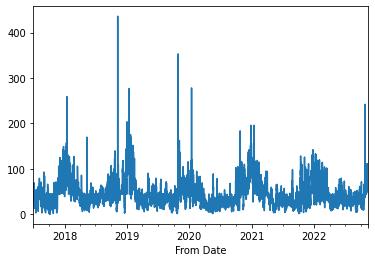

In [27]:
df2 = df['PM2.5']

df2.plot()

In [28]:
def matrixMaker(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [29]:
WINDOW_SIZE = 7
X1, y1 = matrixMaker(df2, WINDOW_SIZE)
X1.shape, y1.shape

((5869, 7, 1), (5869,))

In [30]:
X1

array([[[28.3 ],
        [31.23],
        [45.17],
        ...,
        [40.26],
        [46.94],
        [28.44]],

       [[31.23],
        [45.17],
        [34.57],
        ...,
        [46.94],
        [28.44],
        [40.32]],

       [[45.17],
        [34.57],
        [40.26],
        ...,
        [28.44],
        [40.32],
        [59.46]],

       ...,

       [[83.79],
        [85.9 ],
        [96.06],
        ...,
        [64.08],
        [52.03],
        [55.35]],

       [[85.9 ],
        [96.06],
        [69.38],
        ...,
        [52.03],
        [55.35],
        [60.77]],

       [[96.06],
        [69.38],
        [64.08],
        ...,
        [55.35],
        [60.77],
        [76.84]]])

In [31]:
y1

array([40.32, 59.46, 38.48, ..., 60.77, 76.84, 75.47])

In [32]:
trainSize = 5500
valSize = 100

X_train1, y_train1 = X1[:trainSize], y1[:trainSize]
X_val1, y_val1 = X1[trainSize:trainSize+valSize], y1[trainSize:trainSize+valSize]
X_test1, y_test1 = X1[trainSize+valSize:], y1[trainSize+valSize:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((5500, 7, 1), (5500,), (100, 7, 1), (100,), (269, 7, 1), (269,))

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [34]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [35]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
170/172 [============================>.] - ETA: 0s - loss: 781.7700 - root_mean_squared_error: 27.9601

172/172 [==============================] - 8s 35ms/step - loss: 775.2396 - root_mean_squared_error: 27.8431 - val_loss: 111.6370 - val_root_mean_squared_error: 10.5658
Epoch 2/10
168/172 [============================>.] - ETA: 0s - loss: 325.4146 - root_mean_squared_error: 18.0392

172/172 [==============================] - 6s 35ms/step - loss: 322.7916 - root_mean_squared_error: 17.9664 - val_loss: 96.6202 - val_root_mean_squared_error: 9.8296
Epoch 3/10
171/172 [============================>.] - ETA: 0s - loss: 307.9667 - root_mean_squared_error: 17.5490

172/172 [==============================] - 5s 32ms/step - loss: 308.1237 - root_mean_squared_error: 17.5535 - val_loss: 88.2598 - val_root_mean_squared_error: 9.3947
Epoch 4/10
172/172 [==============================] - 1s 6ms/step - loss: 312.7420 - root_mean_squared_error: 17.6845 - val_loss: 102.9052 - val_root_mean_squared_error: 10.1442
Epoch 5/10
172/172 [==============================] - 1s 6ms/step - loss: 309.9316 - root_mean_squared_error: 17.6049 - val_loss: 95.6212 - val_root_mean_squared_error: 9.7786
Epoch 6/10
172/172 [==============================] - ETA: 0s - loss: 307.5934 - root_mean_squared_error: 17.5383

172/172 [==============================] - 7s 43ms/step - loss: 307.5934 - root_mean_squared_error: 17.5383 - val_loss: 81.4584 - val_root_mean_squared_error: 9.0254
Epoch 7/10
172/172 [==============================] - 1s 6ms/step - loss: 318.4402 - root_mean_squared_error: 17.8449 - val_loss: 96.1248 - val_root_mean_squared_error: 9.8043
Epoch 8/10
172/172 [==============================] - 1s 6ms/step - loss: 308.9691 - root_mean_squared_error: 17.5775 - val_loss: 92.7814 - val_root_mean_squared_error: 9.6323
Epoch 9/10
172/172 [==============================] - 1s 6ms/step - loss: 306.6160 - root_mean_squared_error: 17.5105 - val_loss: 90.9649 - val_root_mean_squared_error: 9.5376
Epoch 10/10
172/172 [==============================] - 1s 6ms/step - loss: 303.1619 - root_mean_squared_error: 17.4115 - val_loss: 84.1308 - val_root_mean_squared_error: 9.1723


In [36]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [37]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

172/172 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,37.548660,40.32
1,39.193317,59.46
2,44.750484,38.48
3,40.536324,47.38
4,42.790558,53.23
...,...,...
5495,30.388327,14.90
5496,22.421974,20.97
5497,23.619959,23.77
5498,25.283131,16.70


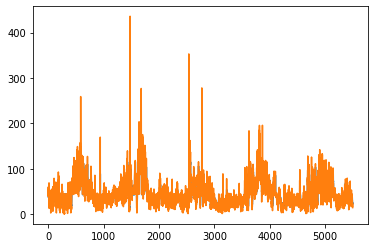

In [38]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [39]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

4/4 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,19.733475,19.17
1,22.368492,11.09
2,18.223608,26.77
3,25.815233,22.45
4,24.826771,18.32
...,...,...
95,30.607615,24.57
96,28.504433,28.45
97,31.078922,26.41
98,30.233620,22.60


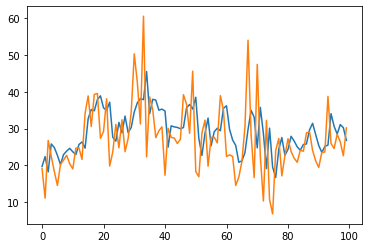

In [40]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [41]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

9/9 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,31.385262,26.20
1,29.844490,29.94
2,32.364117,32.18
3,34.697350,18.62
4,25.770164,22.97
...,...,...
264,71.819473,52.03
265,60.576340,55.35
266,55.888126,60.77
267,56.739532,76.84


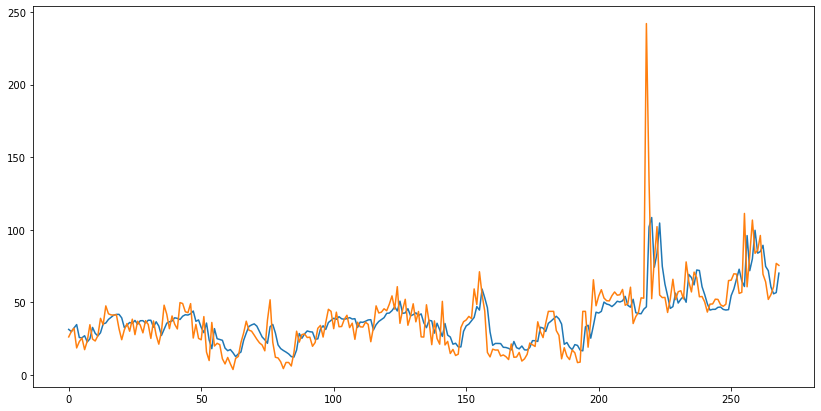

In [42]:
plt.figure(figsize =(14, 7))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_results['Actuals'],test_results['Test Predictions'])
mse

279.23787903144455

In [44]:
rmse = sqrt(mse)
rmse

16.710412293879664